<a href="https://colab.research.google.com/github/madhugrover/Thinkful_projects/blob/master/3layerLSTM_tesla.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import keras
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Bidirectional
from keras.models import Sequential
import pandas as pd 
import pandas_datareader.data as web
import datetime
import numpy as np 
from matplotlib import style

# ignore warnings 
import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


In [0]:
# Get the stock data using yahoo API:
style.use('ggplot')

# get 2014-2019 data to train our model
start = datetime.datetime(2010,6,28)
end = datetime.datetime(2019,12,31)
df = web.DataReader("TSLA", 'yahoo', start, end) 

# get 2019 data to test our model on 
start = datetime.datetime(2020,1,1)
end = datetime.date.today()
test_df = web.DataReader("TSLA",  'yahoo', start, end) 

In [0]:
test_df.tail()

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2020-03-23,442.000000,410.500000,433.600006,434.290009,16454500,434.290009
2020-03-24,513.690002,474.000000,477.299988,505.000000,22895200,505.000000
2020-03-25,557.000000,511.109985,545.250000,539.250000,21222700,539.250000
2020-03-26,560.000000,512.250000,547.390015,528.159973,17380700,528.159973
2020-03-27,525.799988,494.029999,505.000000,514.359985,14352100,514.359985


In [0]:
# sort by date
df = df.sort_values('Date')
test_df = test_df.sort_values('Date')

In [0]:
# fix the date 
df.reset_index(inplace=True)
df.set_index("Date", inplace=True)
test_df.reset_index(inplace=True)
test_df.set_index("Date", inplace=True)

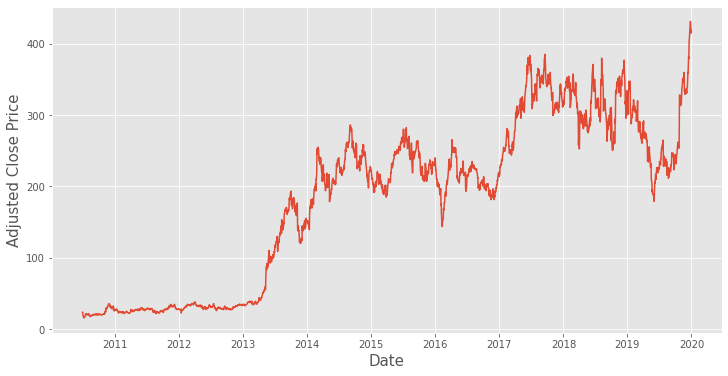

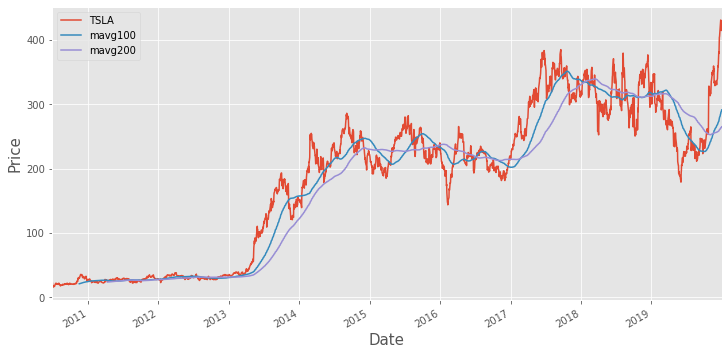

In [0]:
# Visualize the training stock data:
import matplotlib.pyplot as plt
%matplotlib inline

plt.figure(figsize = (12,6))
plt.plot(df["Adj Close"])
plt.xlabel('Date',fontsize=15)
plt.ylabel('Adjusted Close Price',fontsize=15)
plt.show()


# Rolling mean
close_px = df['Adj Close']
mavg = close_px.rolling(window=100).mean()
mavg2 = close_px.rolling(window=200).mean()

plt.figure(figsize = (12,6))
close_px.plot(label='TSLA')
mavg.plot(label='mavg100')
mavg2.plot(label='mavg200')
plt.xlabel('Date',fontsize=15)
plt.ylabel('Price',fontsize=15)
plt.legend();

In [0]:
import matplotlib.dates as mdates

# change the dates into ints for training 
dates_df = df.copy()
dates_df = dates_df.reset_index()

# Store the original dates for plotting the predicitons
org_dates = dates_df['Date']

# convert to ints
dates_df['Date'] = dates_df['Date'].map(mdates.date2num)

dates_df.tail()

,Date,High,Low,Open,Close,Volume,Adj Close
2389,737417.0,425.470001,412.690002,418.359985,425.250000,8054700,425.250000
2390,737419.0,433.480011,426.350006,427.910004,430.940002,10633900,430.940002
2391,737420.0,435.309998,426.109985,435.000000,430.380005,9945700,430.380005
2392,737423.0,429.000000,409.260010,428.790009,414.700012,12586400,414.700012
2393,737424.0,421.290009,402.079987,405.000000,418.329987,10285700,418.329987


In [0]:
# Create train set of adj close prices data:
train_data = df.loc[:,'Adj Close'].as_matrix()
print(train_data.shape) # 1258 

(2394,)


In [0]:
# Apply normalization before feeding to LSTM using sklearn:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
train_data = train_data.reshape(-1,1)

scaler.fit(train_data)
train_data = scaler.transform(train_data)
print(train_data.shape)

(2394, 1)


In [0]:
# Function to create a dataset to feed into an LSTM
def create_dataset(dataset, look_back):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back):
        a = dataset[i:(i + look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return np.array(dataX), np.array(dataY)

In [0]:
# Create the data to train our model on:
look_back = 36
X_train, y_train = create_dataset(train_data, look_back)

# reshape it [samples, time steps, features]
X_train = np.reshape(X_train, (X_train.shape[0], 36, 1))

print(X_train.shape)

(2358, 36, 1)


In [0]:
# Visualizing our data with prints: 
print('X_train:')
print(str(scaler.inverse_transform(X_train[0])))
print("\n")
print('y_train: ' + str(scaler.inverse_transform(y_train[0].reshape(-1,1)))+'\n')

X_train:
[[23.88999939]
 [23.82999992]
 [21.95999908]
 [19.20000076]
 [16.11000061]
 [15.80000019]
 [17.45999908]
 [17.39999962]
 [17.04999924]
 [18.13999939]
 [19.84000015]
 [19.88999939]
 [20.63999939]
 [21.90999985]
 [20.29999924]
 [20.21999931]
 [21.        ]
 [21.29000092]
 [20.95000076]
 [20.54999924]
 [20.71999931]
 [20.35000038]
 [19.94000053]
 [20.92000008]
 [21.95000076]
 [21.26000023]
 [20.45000076]
 [19.59000015]
 [19.60000038]
 [19.03000069]
 [17.89999962]
 [17.60000038]
 [18.31999969]
 [18.78000069]
 [19.14999962]
 [18.77000046]]


y_train: [[18.79000092]]



In [0]:
model = keras.Sequential()
model.add(LSTM(units=50,return_sequences=True,input_shape=(X_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50,return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
model.add(Dense(units=1))
model.compile(optimizer='adam',loss='mean_squared_error')
history = model.fit(X_train,y_train,epochs=50,batch_size=32)

RuntimeError: ignored

KeyError: ignored

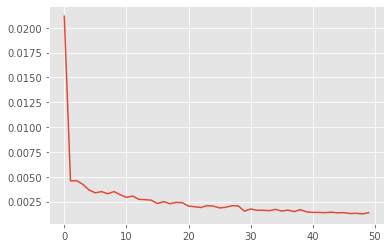

In [0]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

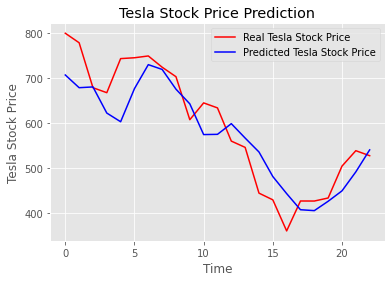

In [0]:
# Get the stock prices for 2020 to have our model make the predictions
test_data = test_df['Adj Close'].values
test_data = test_data.reshape(-1,1)
test_data = scaler.transform(test_data)

# Create the data to test our model on:
time_steps = 36
X_test, y_test = create_dataset(test_data, time_steps)

# store the original vals for plotting the predictions 
y_test = y_test.reshape(-1,1)
org_y = scaler.inverse_transform(y_test)

# reshape it [samples, time steps, features]
X_test = np.reshape(X_test, (X_test.shape[0], 36, 1))

# Predict the prices with the model
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)


# plot the results 
plt.plot(org_y, color = 'red', label = 'Real Tesla Stock Price')
plt.plot(predicted_y, color = 'blue', label = 'Predicted Tesla Stock Price')
plt.title('Tesla Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Tesla Stock Price')
plt.legend()
plt.show()

In [0]:
dataset_total = pd.concat((df['Adj Close'], test_df['Adj Close']), axis = 0)
inputs = dataset_total[len(dataset_total) - len(test_df) - 36:].values
inputs = inputs.reshape(-1,1)
inputs = scaler.transform(inputs)
X_test = []
for i in range(36, 50):
  X_test.append(inputs[i-36:i, 0])
  X_test = np.array(X_test)
  X_test = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
  predicted_stock_price = model.predict(X_test)
  predicted_stock_price = scaler.inverse_transform(predicted_stock_price)

AttributeError: ignored

In [0]:
predicted_y

array([[730.94305],
       [706.6267 ],
       [687.9716 ],
       [637.6283 ],
       [612.4331 ],
       [635.821  ],
       [647.29517],
       [654.857  ],
       [646.9394 ],
       [634.74384],
       [587.50555],
       [583.85913],
       [577.40894],
       [542.234  ],
       [520.0205 ],
       [463.68454],
       [429.34   ],
       [381.24155]], dtype=float32)

In [0]:
predicted_y = list(predicted_y)
result = pd.DataFrame(predicted_y)
result.reset_index(inplace=True)

In [0]:
result

,index,0
0,0,730.943054
1,1,706.626709
2,2,687.971619
3,3,637.628296
4,4,612.433105
5,5,635.820984
6,6,647.295166
7,7,654.856995
8,8,646.939392
9,9,634.743835


In [0]:
org_y = list(org_y)
data = pd.DataFrame(org_y)
data.reset_index(inplace=True)

In [0]:

df_out = pd.DataFrame(list(zip(org_y, predicted_y)))

In [0]:
df_out.dtypes

0    object
1    object
dtype: object

In [0]:
import pickle
pickle_out = pickle.dump(model, open("lstm_model", "wb"))

In [0]:
model = pickle.load(open("lstm_model", 'rb'))

In [0]:
model

In [0]:
predicted_y = model.predict(X_test)
predicted_y = scaler.inverse_transform(predicted_y)

In [0]:
predicted_y

array([[730.94305],
       [706.6267 ],
       [687.9716 ],
       [637.6283 ],
       [612.4331 ],
       [635.821  ],
       [647.29517],
       [654.857  ],
       [646.9394 ],
       [634.74384],
       [587.50555],
       [583.85913],
       [577.40894],
       [542.234  ],
       [520.0205 ],
       [463.68454],
       [429.34   ],
       [381.24155]], dtype=float32)